## Have a try to image hog
Import Libraries

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
def opponent_cs(image):
    
    image = image/np.max(image)
    
    R  = image[:,:,0]
    G  = image[:,:,1]
    B  = image[:,:,2]

    ch1 = np.abs(R-G)/np.sqrt(2);
    ch2 = np.abs(R+G-2*B)/np.sqrt(6);
    ch3 = (R+G+B)/np.sqrt(3);
    
    img_out = np.dstack((ch1,ch2,ch3))
    img_out = np.clip(255*img_out/np.max(img_out), 0, 255).astype('uint8')
    
    return img_out
    

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
        # Use skimage.hog() to get both features
        # If vis is True, visualization is also returned
        return hog(img, orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell), 
                    cells_per_block=(cell_per_block, cell_per_block), 
                    transform_sqrt=True, visualise=vis, feature_vector=feature_vec)

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    return cv2.resize(img, size).ravel()

def convert_color(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'Opponent':
            feature_image = opponent_cs(image)
                        
    else: feature_image = np.copy(image)
    
    return feature_image

def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, hog_cspace='RGB', hist_cspace='HSV', spatial_size=(32, 32), hist_bins=32,
                    orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
         # Read in each one by one
        image = np.array(Image.open(file))
        
        hist_image = convert_color(image, hist_cspace)        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(hist_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(hist_image, nbins=hist_bins)
        
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, hog_cspace)
        
        
        hog_ch0 = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, vis, feature_vec)
        hog_ch1 = get_hog_features(feature_image[:,:,1], orient, pix_per_cell, cell_per_block, vis, feature_vec)
        hog_ch2 = get_hog_features(feature_image[:,:,2], orient, pix_per_cell, cell_per_block, vis, feature_vec)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((hog_ch0, hog_ch1, hog_ch2, spatial_features, hist_features)))
        
    # Return list of feature vectors
    return features

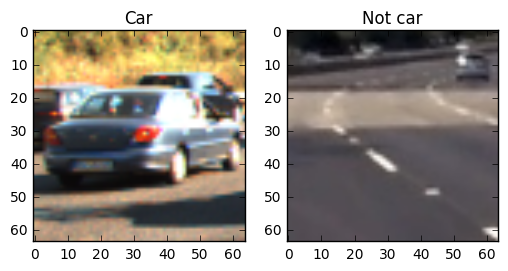

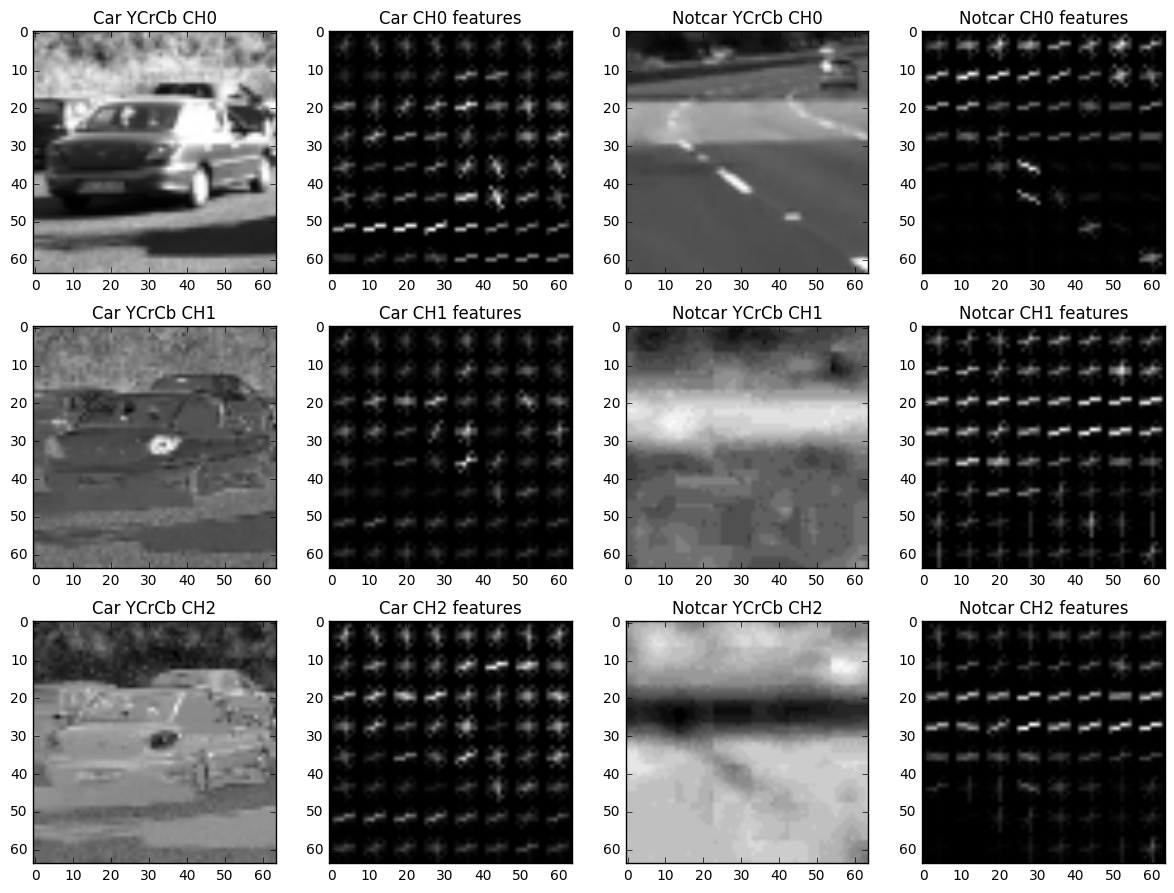

In [4]:
# Visualize one image 
image = np.array(Image.open('./test_images/173.png'))
image2 = np.array(Image.open('./test_images/extra67.png'))

hog_cspace = 'YCrCb'

hist_cspace = 'HSV'
#hist_cspace = 'YCrCb'

img_converted = convert_color(image, hog_cspace)
img2_converted = convert_color(image2, hog_cspace)

plt.figure()
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(image)
ax1.set_title('Car')
ax2.imshow(image2)
ax2.set_title('Not car')

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

images = []
titles = []
images.append(img_converted[:,:,0])
titles.append('Car {} CH0'.format(hog_cspace))
images.append(img_converted[:,:,1])
titles.append('Car {} CH1'.format(hog_cspace))
images.append(img_converted[:,:,2])
titles.append('Car {} CH2'.format(hog_cspace))

# Call our function with vis=True to see an image output
car_hog0, car_hog0_img = get_hog_features(img_converted[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
images.append(car_hog0_img)
titles.append('Car CH0 features')

car_hog1, car_hog1_img = get_hog_features(img_converted[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
images.append(car_hog1_img)
titles.append('Car CH1 features')

car_hog2, car_hog2_img = get_hog_features(img_converted[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
images.append(car_hog2_img)
titles.append('Car CH2 features')

images.append(img2_converted[:,:,0])
titles.append('Notcar {} CH0'.format(hog_cspace))
images.append(img2_converted[:,:,1])
titles.append('Notcar {} CH1'.format(hog_cspace))
images.append(img2_converted[:,:,2])
titles.append('Notcar {} CH2'.format(hog_cspace))

# Call our function with vis=True to see an image output
notcar_hog0, notcar_hog0_img = get_hog_features(img2_converted[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
images.append(notcar_hog0_img)
titles.append('Notcar CH0 features')

notcar_hog1, notcar_hog1_img = get_hog_features(img2_converted[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
images.append(notcar_hog1_img)
titles.append('Notcar CH1 features')

notcar_hog2, notcar_hog2_img = get_hog_features(img2_converted[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
images.append(notcar_hog2_img)
titles.append('Notcar CH2 features')

rows = 3
cols = 4
# Plot the examples
fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(rows, cols)

for row_idx in range(rows):
    for col_idx in range(cols):
        ax = plt.subplot(gs[cols * row_idx + col_idx])
        ax.imshow(images[col_idx * rows + row_idx], cmap='gray')
        ax.set_title(titles[col_idx * rows + row_idx])
fig.tight_layout()

What we can play with:
1 other color space
2 the parameters


## Read in all images to array and generate hog descriptors 

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
%matplotlib inline

# Read in our vehicles and non-vehicles
cars = glob.glob('/home/roy/data/p5/vehicles/*/*.png')
notcars = glob.glob('/home/roy/data/p5/non-vehicles/*/*.png')

n_cars = len(cars)
n_notcars = len(notcars)
print('number of cars: {}'.format(len(cars)))
print('number of not cars: {}'.format(len(notcars)))

spatial_size = (32, 32)
hist_bins = 32

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# read one image to learn about its size
ind = np.random.randint(0, len(cars))
image = np.array(Image.open(cars[ind]))
img_h, img_w = image.shape[:2]


cars_features = extract_features(cars, hog_cspace,
                                 hist_cspace,
                                 spatial_size,
                                 hist_bins,
                                 orient,
                                 pix_per_cell,
                                 cell_per_block)

not_cars_features = extract_features(notcars, hog_cspace,
                                 hist_cspace,
                                 spatial_size,
                                 hist_bins,
                                 orient, 
                                 pix_per_cell, 
                                 cell_per_block)

all_features = np.vstack((cars_features, not_cars_features)).astype('float')

all_labels = np.hstack((np.ones(n_cars), np.zeros(n_notcars)))

print('fetures and labels are ready')


number of cars: 8792
number of not cars: 8968
fetures and labels are ready


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time
import pickle

#Normalize the feature value
features_scaler = StandardScaler().fit(all_features)

# Apply the scaler to features
scaled_features = features_scaler.transform(all_features)

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, all_labels, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

data_dict = {
    'svc': svc,
    'scaler' : features_scaler,
    'orient' : orient,
    'pix_per_cell' : pix_per_cell,
    'cell_per_block' : cell_per_block,
    'spatial_size': spatial_size,
    'hist_bins': hist_bins
}

with open('./svc_pickle.p', 'wb') as fp:
    pickle.dump(data_dict,fp)
    

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
3.81 Seconds to train SVC...
Test Accuracy of SVC =  0.9941
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  0.  1.  1.  0.]
0.00212 Seconds to predict 10 labels with SVC


Try different color space to check which has more information

Already got svc model, try search window now.

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label
from glob import glob
from tools import natural_keys
%matplotlib inline

In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    #draw_img = np.copy(img)
    
    #print('image shape {}'.format(img.shape))
    img_tosearch = img[ystart:ystop,xstart:xstop, :]
    
    # convert RGB to YCrCb
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = convert_color(img_tosearch, cspace=hog_cspace)
    hist_tosearch = convert_color(img_tosearch, cspace=hist_cspace)
    
    # resize the image
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        hist_tosearch = cv2.resize(hist_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    #get three channels
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above for the whole searching image
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = hist_tosearch[ytop:ytop+window, xleft:xleft+window]
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features,spatial_features, 
                                                          hist_features)).reshape(1, -1))    
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart), \
                #              (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left+xstart, ytop_draw + ystart), \
                                  (xbox_left+win_draw+xstart, ytop_draw+win_draw + ystart)))
                
    return bbox_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 20

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



orient 9
pix_per_cell 8
cell_per_block 2
spatial_size (32, 32)
hist_bins 32


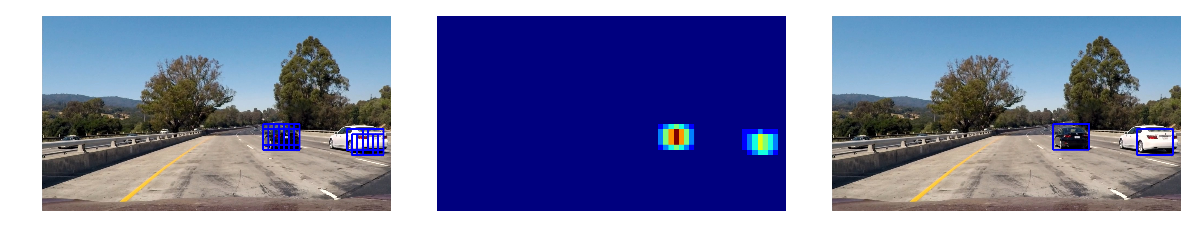

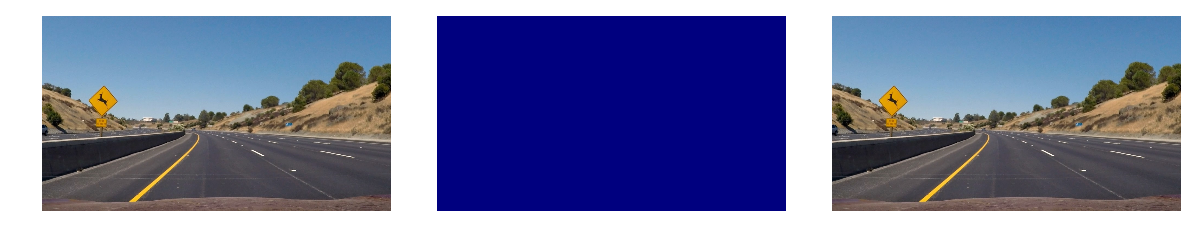

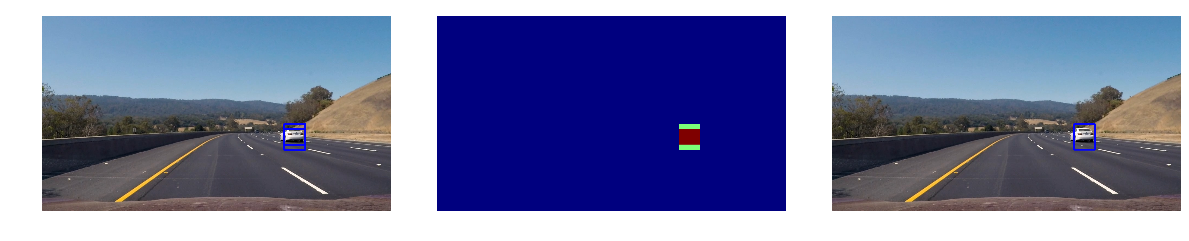

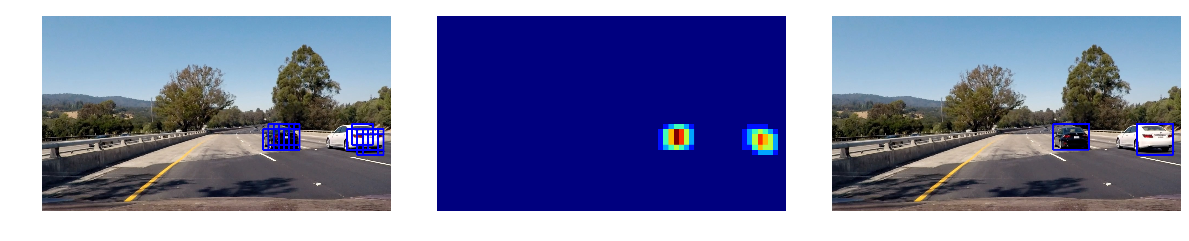

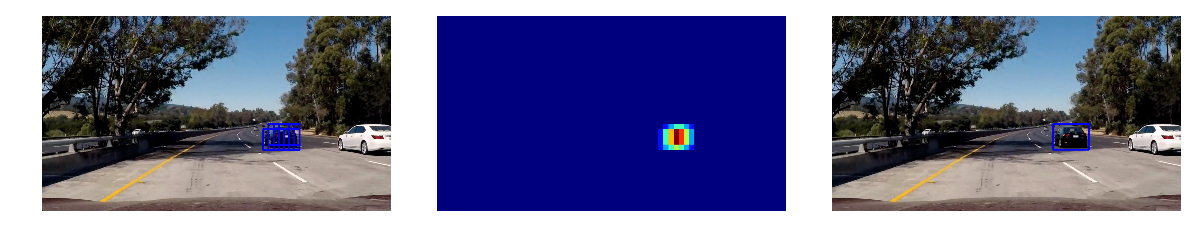

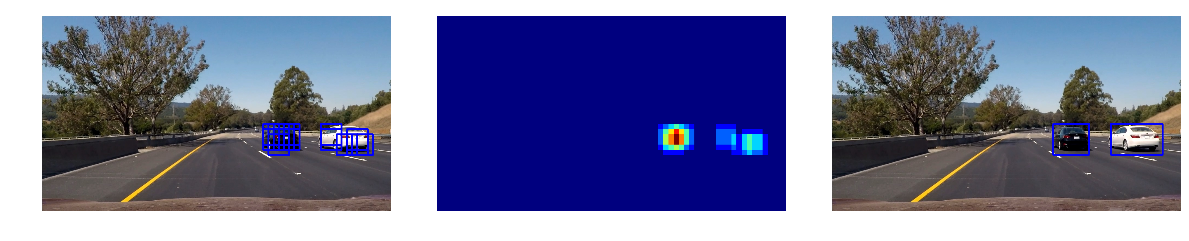

In [10]:
# test the find_cars

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

print('orient', orient)
print('pix_per_cell', pix_per_cell)
print('cell_per_block', cell_per_block)
print('spatial_size', spatial_size)
print('hist_bins', hist_bins)

ystart = 400
ystop = 600
    
xstart = 600
xstop = 1280

image_files = glob('./test_images/test*.jpg')
image_files.sort(key=natural_keys)

for file_name in image_files:
    image = np.array(Image.open(file_name))

    draw_img = np.copy(image)
    
    #scales = [1, 1.2, 1.6, 2]
    scales = [1.2]
    
    bbox_all = []
    for scale in scales:
        bbox_list = find_cars(image, ystart, ystop, xstart, xstop, scale, svc, 
                                      X_scaler, orient, pix_per_cell, cell_per_block)
        bbox_all.append(bbox_list)
    
    for bbox in sum(bbox_all, []):
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
    
    #print('bbox', bbox_list)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, sum(bbox_all, []))
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heat_map = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heat_map)
    
    bbox_img = draw_labeled_bboxes(image, labels)
    
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(draw_img)
    plt.subplot(132)
    plt.axis('off')
    plt.imshow(heat_map)
    plt.subplot(133)
    plt.axis('off')
    plt.imshow(bbox_img)
    plt.tight_layout()


In [15]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]


def pipe_line(image):
    ystart = 400
    ystop = 600
    
    xstart = 600
    xstop = 1280

    scales = [1, 1.5, 2]
    
    bbox_all = []
    for scale in scales:
        bbox_list = find_cars(image, ystart, ystop, xstart, xstop, scale, svc, 
                                      X_scaler, orient, pix_per_cell, cell_per_block)
        bbox_all += bbox_list

    bboxes_nframes.append(bbox_all)
    if len(bboxes_nframes) > nframes_th:
        bboxes_nframes.pop(0)
        
    #print('bbox', bbox_list)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, sum(bboxes_nframes, []))
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 20)

    # Visualize the heatmap when displaying    
    heat_map = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heat_map)
    
    bbox_img = draw_labeled_bboxes(image, labels)
    
    return bbox_img

"\nbboxes_nframes = []\nnframes_th = 5\n\n#img = np.array(Image.open('./bbox-example-image.jpg'))\nimg = np.array(Image.open('./test_images/test3.jpg'))\n\ndraw_img = pipe_line(img)\n\nfig = plt.figure(figsize=(12,9))\nplt.subplot(121)\nplt.imshow(draw_img)\nplt.title('Car Positions')\nplt.subplot(122)\nplt.imshow(heat)\nplt.title('heatmap')\n"

In [16]:
from moviepy.editor import VideoFileClip
project_output = 'project_out.mp4'
clip1 = VideoFileClip("project_video.mp4")

bboxes_nframes = []
nframes_th = 3

project_clip = clip1.fl_image(pipe_line)
project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_out4.mp4
[MoviePy] Writing video test_out4.mp4


100%|█████████▉| 1260/1261 [10:11<00:00,  2.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_out4.mp4 

